In [1]:
import numpy as np
import skimage as sk
from skimage import morphology as skm
import cv2
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

#Setup

In [4]:
#FIXME setup the folder location
TRAIN_FOLDER = "Data/TRAIN/"
EX_FOLDER = "Data/"

In [5]:
ex_imgs = [EX_FOLDER + path for path in os.listdir(EX_FOLDER) if path[:2] == "ex" and path[-3:] == "jpg"]
ex_imgs.sort()

In [6]:
ex_csv = [EX_FOLDER + path for path in os.listdir(EX_FOLDER) if path[:2] == "ex" and path[-3:] == "csv"]
ex_csv.sort()

In [7]:
train_imgs = [TRAIN_FOLDER + path for path in os.listdir(TRAIN_FOLDER) if path[-3:] == "jpg"]
train_imgs.sort()

In [8]:
def plot_images(path_lst, csv=None, max=6):
    plt.figure(figsize=(20,15))
    for i, path in enumerate(path_lst):
        if i == max:
            break
        plt.subplot(max//2, 2, i+1)
        if csv:
            for point in np.genfromtxt(csv[i],delimiter=','):
                plt.plot(point[1], point[0], marker='x', color="red")
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2LAB)
        im,_,_ = cv2.split(im)
        #im = im - cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        #im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        plt.imshow(im, cmap="gray")
        
    plt.show()

##Exemples visualisation

In [9]:
plot_images(ex_imgs,csv=ex_csv, max=4)

# Pre-processing - Blood vessel segmentation

Conversion to LAB color space

The LAB color space will help make all our images to look similar with the L channel

CPU times: user 87.1 ms, sys: 0 ns, total: 87.1 ms
Wall time: 61.4 ms


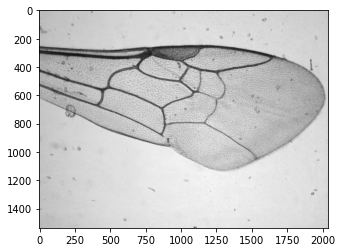

In [10]:
%time im = cv2.cvtColor(cv2.imread(train_imgs[27]), cv2.COLOR_BGR2LAB)
im_l,_,_ = cv2.split(im)
plt.imshow(im_l, cmap="gray")

Cleaning the image with a small gaussianBlur

CPU times: user 6.64 ms, sys: 579 µs, total: 7.22 ms
Wall time: 2.45 ms


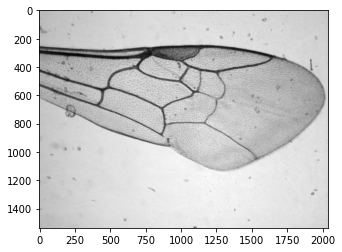

In [11]:
%time im_gau = cv2.GaussianBlur(im_l, (5,5), 3.0)
plt.imshow(im_gau, cmap="gray")

This function will help use to segment area of interest in the image 

In [12]:
def differenceOfGaussian(img, k1, k2):
    g1 = cv2.blur(img, (k1, k1))
    g2 = cv2.blur(img, (k2, k2))
    return g1 - g2

CPU times: user 7.97 ms, sys: 3.68 ms, total: 11.6 ms
Wall time: 11 ms


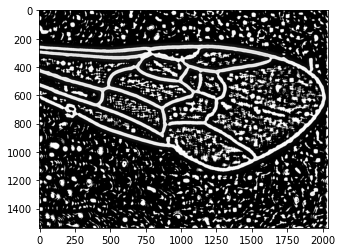

In [13]:
%time im_diff = differenceOfGaussian(im_gau, 25, 50)
plt.imshow(im_diff, cmap="gray")

In [14]:
im_treshold = np.uint8(im_diff > 60)

Using cv2 morphology because it's faster than skimage tools

We remove smalls objects on the image by using a white tophat

In [15]:
%time im_top = cv2.morphologyEx(im_treshold, cv2.MORPH_TOPHAT, skm.disk(10))
im_top = im_treshold - im_treshold * im_top
plt.imshow( im_top, cmap="gray")

CPU times: user 51.1 ms, sys: 0 ns, total: 51.1 ms
Wall time: 50.9 ms


Cleaning or image with some dilatation and erosion

In [16]:
im_open = cv2.dilate(im_top, skm.disk(2), iterations=4)
im_open = cv2.erode(im_open, skm.disk(2), iterations=8)
im_open = cv2.dilate(im_open, skm.disk(2), iterations=2)
plt.imshow(im_open, cmap="gray")

We sort connected elements by size and keep only biggest ones

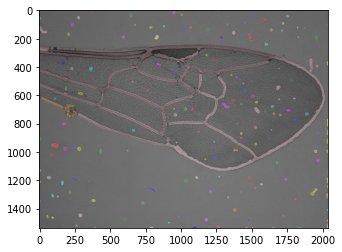

In [17]:
im_label = sk.measure.label(im_open)
im_label_overlay = sk.color.label2rgb(im_label, image=im_l, bg_label=0)
plt.imshow(im_label_overlay)

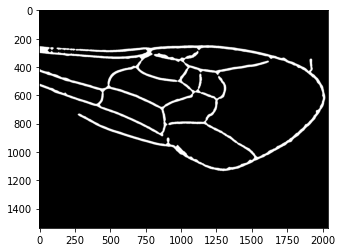

In [18]:
tmp = np.where(np.bincount(im_label.flatten()) > 25000)[0][1:]
im_filter = np.zeros_like(im_label).astype(bool)
for value in tmp:
    im_filter = im_filter | (im_label == value)
plt.imshow(im_filter, cmap="gray")

Apply a series of dilatation and erosion to try to reconnect cut vessels

In [19]:
im_filter_morph = cv2.dilate(np.uint8(im_filter), skm.disk(1) ,iterations = 10)
im_filter_morph = cv2.erode(np.uint8(im_filter_morph), skm.disk(1) ,iterations = 7)
im_filter_morph = cv2.dilate(np.uint8(im_filter_morph), skm.disk(1) ,iterations = 5)
im_filter_morph = cv2.erode(np.uint8(im_filter_morph), skm.disk(1) ,iterations = 3)
plt.imshow(im_filter_morph, cmap="gray")

And then we skeletonize or image to keep only important info, and it will help use for the next step

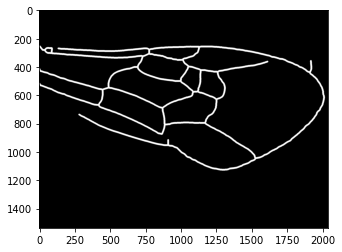

In [20]:
skeleton = skm.skeletonize(im_filter_morph)
plt.imshow(cv2.dilate(np.uint8(skeleton), skm.disk(3) ,iterations = 2), cmap="gray")

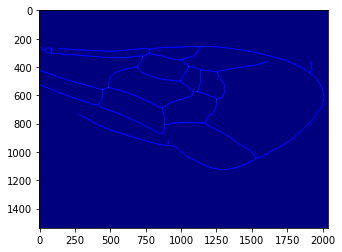

In [21]:
plt.imshow(skeleton, cmap="jet")

#Intersection detection

In [22]:
def my_subtract(a,b):
    res = np.copy(a)
    if a.shape[0] % 2 == 0 or a.shape[1] != a.shape[0] or b.shape[0] % 2 == 0 or b.shape[1] != b.shape[0]:
        return
    dif = abs(a.shape[0] // 2 - b.shape[0] // 2)
    for i in range(b.shape[0]):
        for j in range(b.shape[0]):
            res[dif+i,dif+j] -= b[i,j]
    return res  

We are using a ring kernel to detect intersection of at least 3 vessels

We cover all the image by moving of (int(pading / 1.5)) to have a good ratio between speed and precision

In [23]:
ring = my_subtract(skm.square(23), skm.square(21))

In [24]:
%%time
pading = len(ring)
points = np.zeros_like(im_l)
for i in range(0, skeleton.shape[1] - pading, int(pading / 1.5)):
    for j in range(0, skeleton.shape[0] - pading, int(pading / 1.5)):
        window = skeleton[j:j + pading, i:i + pading] * ring
        if window.sum() < 3:
            continue
        #using sk.measure.label to avoid special case where the vessel is parallel with the kernel 
        labels = len(np.bincount(sk.measure.label(window).flatten()))
        if labels > 3 :
            points[j + pading // 2, i + pading // 2] = 1

CPU times: user 146 ms, sys: 365 µs, total: 146 ms
Wall time: 142 ms


This function recenters points if they are to close to each other

In [25]:
def get_centroids(img):
    im = cv2.dilate(img, skm.disk(5) ,iterations = 2)
    _,_,_,centroids = cv2.connectedComponentsWithStats(im, connectivity=8)
    return centroids

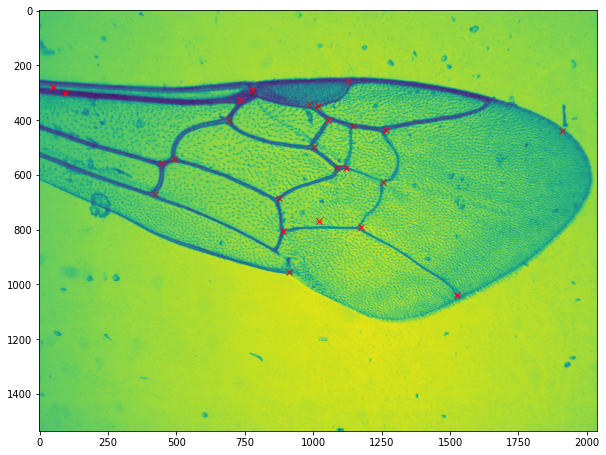

In [26]:
plt.figure(figsize=(10,15))
centroids = get_centroids(points)
for point in centroids :
        plt.plot(point[0], point[1], marker='x', color="red")
plt.imshow(im_l)

#Pipeline


In [27]:
def differenceOfGaussian(img, k1, k2):
    g1 = cv2.blur(img, (k1, k1))
    g2 = cv2.blur(img, (k2, k2))
    return g1 - g2

def my_subtract(a,b):
    res = np.copy(a)
    if a.shape[0] % 2 == 0 or a.shape[1] != a.shape[0] or b.shape[0] % 2 == 0 or b.shape[1] != b.shape[0]:
        return
    dif = abs(a.shape[0] // 2 - b.shape[0] // 2)
    for i in range(b.shape[0]):
        for j in range(b.shape[0]):
            res[dif+i,dif+j] -= b[i,j]
    return res
    
def get_centroids(img):
    im = cv2.dilate(img, skm.disk(5) ,iterations = 2)
    _,_,_,centroids = cv2.connectedComponentsWithStats(im, connectivity=8)
    return centroids

def detection(path):
    im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2LAB)
    im_l,_,_ = cv2.split(im)
    im_gau = cv2.GaussianBlur(im_l, (5,5), 3.0)
    im_diff = differenceOfGaussian(im_gau, 25, 50)
    im_treshold = np.uint8(im_diff > 60)
    im_top = cv2.morphologyEx(im_treshold, cv2.MORPH_TOPHAT, skm.disk(10))
    im_top = im_treshold - im_treshold * im_top
    im_morph = cv2.dilate(im_top, skm.disk(2), iterations=4)
    im_morph = cv2.erode(im_morph, skm.disk(2), iterations=8)
    im_morph = cv2.dilate(im_morph, skm.disk(2), iterations=2)
    im_label = sk.measure.label(im_morph)
    tmp = np.where(np.bincount(im_label.flatten()) > 25000)[0][1:]
    im_filter = np.zeros_like(im_label).astype(bool)
    for value in tmp:
        im_filter = im_filter | (im_label == value)
    im_filter_morph = cv2.dilate(np.uint8(im_filter), skm.disk(1) ,iterations = 10)
    im_filter_morph = cv2.erode(np.uint8(im_filter_morph), skm.disk(1) ,iterations = 7)
    im_filter_morph = cv2.dilate(np.uint8(im_filter_morph), skm.disk(1) ,iterations = 5)
    im_filter_morph = cv2.erode(np.uint8(im_filter_morph), skm.disk(1) ,iterations = 3)
    skeleton = skm.skeletonize(im_filter_morph)
    ring = my_subtract(skm.square(23), skm.square(21))
    pading = len(ring)
    points = np.zeros_like(im_l)
    for i in range(0, skeleton.shape[1] - pading, int(pading / 1.5)):
        for j in range(0, skeleton.shape[0] - pading, int(pading / 1.5)):
            window = skeleton[j:j + pading, i:i + pading] * ring
            if window.sum() < 3:
                continue
            labels = len(np.bincount(sk.measure.label(window).flatten()))
            if labels > 3 :
                points[j + pading // 2, i + pading // 2] = 1
    return get_centroids(points)


#Test

CPU times: user 675 ms, sys: 8.04 ms, total: 683 ms
Wall time: 629 ms


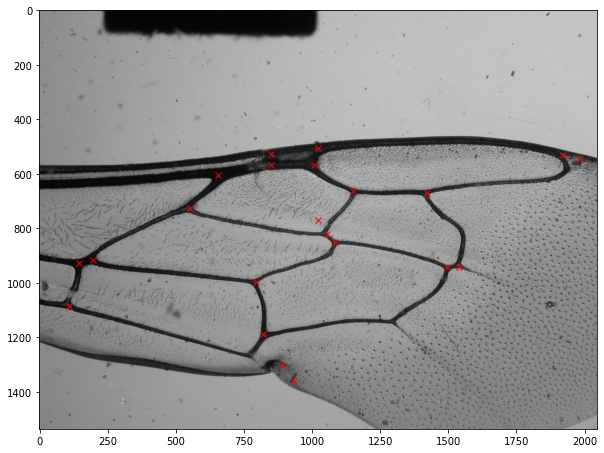

In [40]:

idx = 17 #CHANGE THE INDEX HERE

plt.figure(figsize=(10,15))
path = train_imgs[idx]
%time centroids = detection(path)
for point in centroids:
        plt.plot(point[0], point[1], marker='x', color="red")
im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
plt.imshow(im)